In [1]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


import gif

from dask.distributed import Client, LocalCluster

import numpy as np
import pandas as pd

from patsy import dmatrices
from sklearn.linear_model import LogisticRegression

## Cover Gif

In [2]:
samples = np.random.normal(size=100000)

@gif.frame
def plot(subsample, num_bootstrap_samples):
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=100);
    #     fig.set_size_inches(10, 15)

    plt1 = axs
    p_95 = np.percentile(subsample, 95)
    p_05 = np.percentile(subsample, 5)
    mean = np.mean(subsample)

    plt1.set_title(f"{num_bootstrap_samples} Bootstrap Samples");
    plt1.hist(subsample, bins=min(100, len(subsample)), density=True);
    plt1.set_xlabel('Bootstrapped statistic');
    plt1.axes.get_yaxis().set_visible(False);
    plt1.axvline(p_05, color='r', linestyle='dashed', label='5th Percentile');
    plt1.axvline(mean, color='k', linestyle='dashed', label='Mean');
    plt1.axvline(p_95, color='g', linestyle='dashed', label='95th Percentile');
    plt1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper right');
    
    
# plot(samples, 1000) 
frames = []
steps = (
    list(range(0, 100, 10)) + # 10
    list(range(100, 1000, 100)) + #10
    list(range(1000, 10000, 1000)) + # 10
    [10000]
)
for num_bootstrap_samples in steps:
    num_bootstrap_samples = num_bootstrap_samples or 1  
    subsample = samples[0:num_bootstrap_samples]
    frame = plot(subsample, num_bootstrap_samples)
    frames.append(frame)

In [27]:
gif.save(frames, "cover.gif", duration=300, unit='ms')

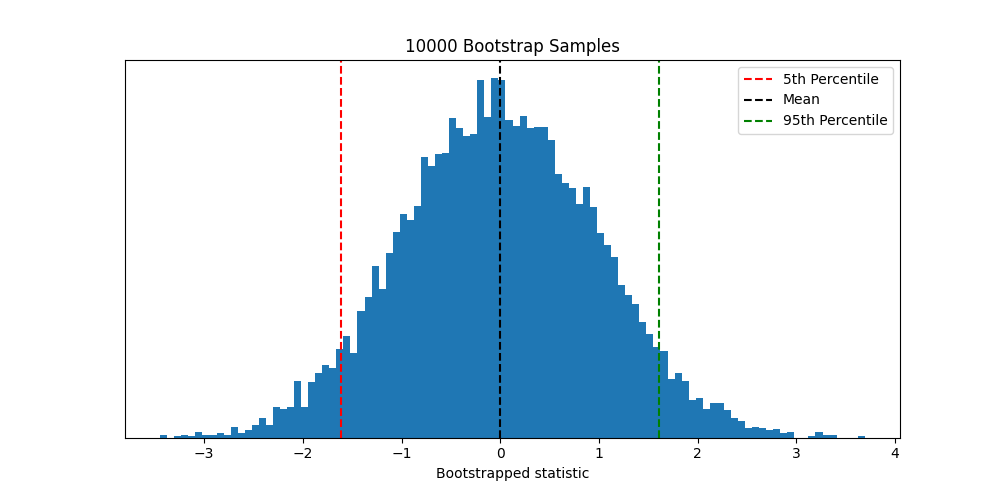

In [28]:
frames[-1]

# Generating bootstrap samples

In [ ]:
def fit_model_and_get_att(filename, df, iteration):
    # Randomly sample data
    model_df = df.sample(replace=True, n=df.shape[0], random_state=iteration)

    # Fit causal model
    model_formula = 'is_purchase_made ~ confounder_1 + confounder_2 + treatment_variable'
    _, X = dmatrices(
                (model_formula), 
                model_df, 
                return_type = 'dataframe'
            )
    y = model_df.is_completed.astype(float)

    model = LogisticRegression(random_state=0, max_iter=1000)
    fitted_model = model.fit(X, y)

    # Predict what would have happened WITH treatment
    treated_df = X[X['treatment_variable[T.True]'] == 1].copy()
    treated_preds = fitted_model.predict_proba(treated_df)[:, 1]

    # Predict what would have happend WITHOUT treatment
    treated_df_no_treatment = treated_df.copy()
    treated_df_no_treatment['treatment_variable[T.True]'] = 0
    treated_no_treatment_preds = fitted_model.predict_proba(treated_df_no_treatment)[:, 1]

    # Calculate average treatment effect on the treated (att) & safe to file!
    treatment_effect_on_treated = treated_preds - treated_no_treatment_preds
    att = treatment_effect_on_treated.mean()
    with open(filename, "a") as f_out:
        f_out.write(f"{att}\n")

    return att

In [ ]:
# Even though my macbook has 16 cores, I only used 12 workers since you'll need enough
# memory to have a copy of the dataset stored in RAM for each worker
# so if df is 1.5GB, you'd need 18GB of RAM with 12 workers
cluster = LocalCluster(n_workers=12, threads_per_worker=1, processes=True)
client = Client(cluster)

_atts = []
scattered_df = client.scatter(df, broadcast=True)
for iteration in range(0, 10000):
    _att = dask.delayed(fit_model_and_get_att)("bootstrap_results.txt", scattered_df, iteration)
    _atts.append(_att)

atts = dask.compute(*_atts)

# Calculate % changes & GIF-it

In [4]:
all_atts = []
with open("bootstrap_results.txt", "r") as f_in:
    contents = f_in.read()
    for line in contents.strip().split('\n'):
        all_atts.append(float(line))

In [5]:
num_iterations = len(all_atts)

p_05s = [np.percentile(all_atts[0:x+1], 5) for x in range(0, num_iterations)]
p_95s = [np.percentile(all_atts[0:x+1], 95) for x in range(0, num_iterations)]
means = [np.mean(all_atts[0:x+1]) for x in range(0, num_iterations)]

# percent difference 
pd_p_05s = [0] + [np.abs((p_05s[x]-p_05s[x-1])/p_05s[x-1]) for x in range(1, num_iterations)]
pd_p_95s = [0] + [np.abs((p_95s[x]-p_95s[x-1])/p_95s[x-1]) for x in range(1, num_iterations)]
pd_means = [0] + [np.abs((means[x]-means[x-1])/means[x-1]) for x in range(1, num_iterations)]


# absolute differnece
ad_p_05s = [0] + [np.abs((p_05s[x]-p_05s[x-1])) for x in range(1, num_iterations)]
ad_p_95s = [0] + [np.abs((p_95s[x]-p_95s[x-1])) for x in range(1, num_iterations)]
ad_means = [0] + [np.abs((means[x]-means[x-1])) for x in range(1, num_iterations)]

In [84]:
@gif.frame
def plot(atts, num_bootstrap_samples):
#     fig, axs = plt.subplots(3, 1, figsize=(7, 10), dpi=150);
#     fig.set_size_inches(10, 15)

    fig = plt.figure(constrained_layout=True, figsize=(10, 5), dpi=150)
    gs = fig.add_gridspec(4, 4)


    plt1 = fig.add_subplot(gs[0:4, 2:])
    plt2 = fig.add_subplot(gs[0:2, :-2])
    plt3 = fig.add_subplot(gs[2:4, :-2])

    p_95 = np.percentile(atts, 95)
    p_05 = np.percentile(atts, 5)
    mean = np.mean(atts)

    fig.suptitle(f"{num_bootstrap_samples} Bootstrap Samples")
    
#     plt1.set_title(f"{num_bootstrap_samples} Bootstrap Samples");
    plt1.hist(atts, bins=min(100, len(atts)), density=True);
    plt1.set_xlabel('Average Treatment Effect on the Treated');
    plt1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    plt1.axes.get_yaxis().set_visible(False);
    plt1.axvline(p_05, color='r', linestyle='dashed', label='5th Percentile');
    plt1.axvline(mean, color='k', linestyle='dashed', label='Mean');
    plt1.axvline(p_95, color='g', linestyle='dashed', label='95th Percentile');
    plt1.legend(bbox_to_anchor=(1.0, 1.25), loc='upper right');
    # plt.

    plt2.plot(range(0, num_bootstrap_samples), p_05s[0:num_bootstrap_samples], color='r', label='5th Percentile');
    plt2.plot(range(0, num_bootstrap_samples), p_95s[0:num_bootstrap_samples], color='k', label='Mean');
    plt2.plot(range(0, num_bootstrap_samples), means[0:num_bootstrap_samples], color='g', label='95th Percentile');
    plt2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
    plt2.set_title('Average Treatment Effect on the Treated')
#     plt2.set_xlabel('Bootstrap Iteration #')
    plt2.axes.get_xaxis().set_visible(False);
    # plt2.legend();

    plt3.plot(range(0, num_bootstrap_samples), pd_p_05s[0:num_bootstrap_samples], color='r', linestyle='dashed', label='5th Percentile');
    plt3.plot(range(0, num_bootstrap_samples), pd_p_95s[0:num_bootstrap_samples], color='k', label='Mean');
    plt3.plot(range(0, num_bootstrap_samples), pd_means[0:num_bootstrap_samples], color='g', label='95th Percentile');
    plt3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
    plt3.set_title('% Change from Previous Iteration');
    plt3.set_xlabel('Bootstrap Iteration #');
    # plt3.legend();

# plot(atts, 1000)

frames = []
steps = (
    list(range(0, 100, 10)) + # 10
    list(range(100, 1000, 100)) + #10
    list(range(1000, 10000, 1000)) + #10
    [10000]
)
for num_bootstrap_samples in steps:
    num_bootstrap_samples = num_bootstrap_samples or 1  
    atts = all_atts[0:num_bootstrap_samples]
    frame = plot(atts, num_bootstrap_samples)
    frames.append(frame)

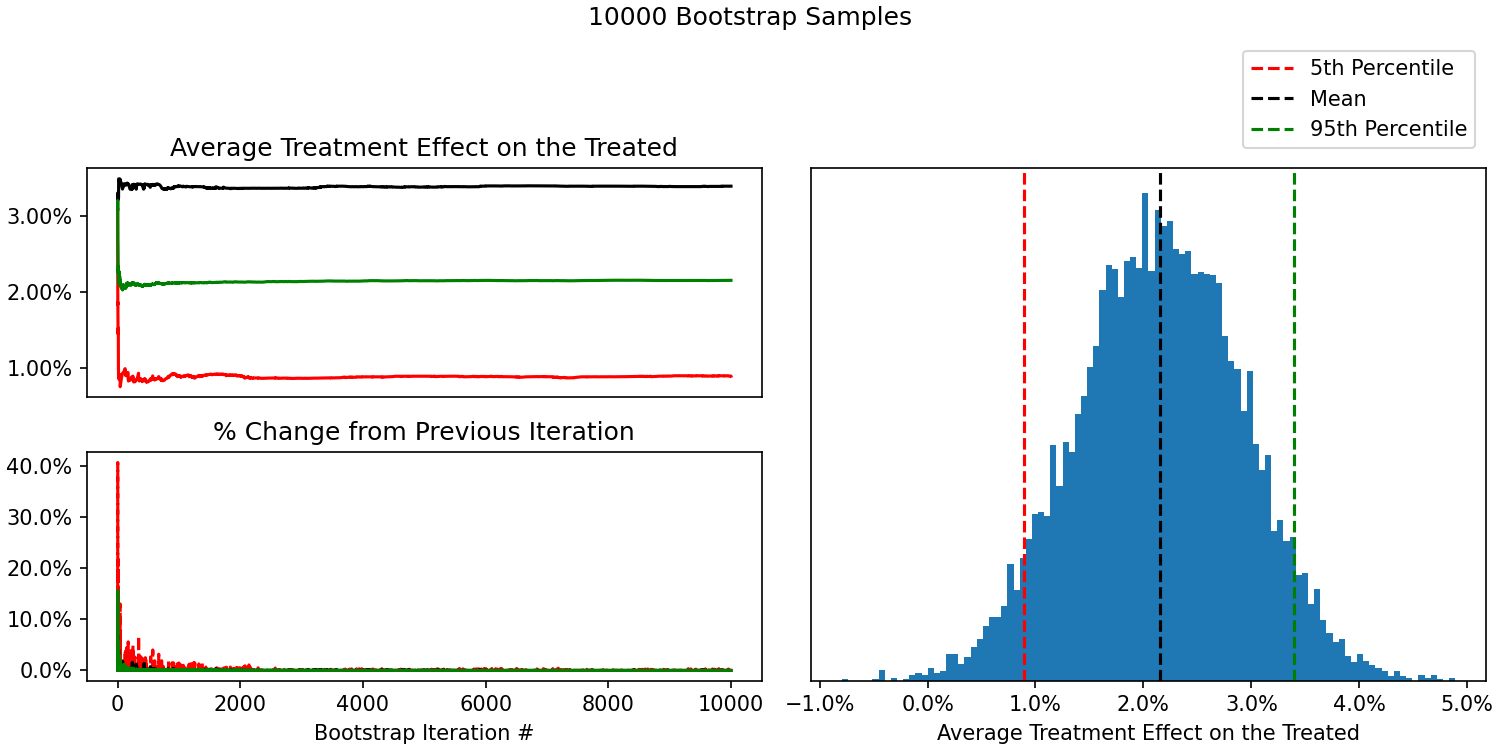

In [85]:
frames[-1]

In [88]:
# gif.save(frames, "bootstrap.gif", duration=20) # duration does not affect size
# gif.save(frames[0:10], "bootstrap.gif", duration=500, unit='ms')
gif.save(frames, "how_many_bootstrap_samples_v2.gif", duration=500, unit='ms')

## When does it stabilize?

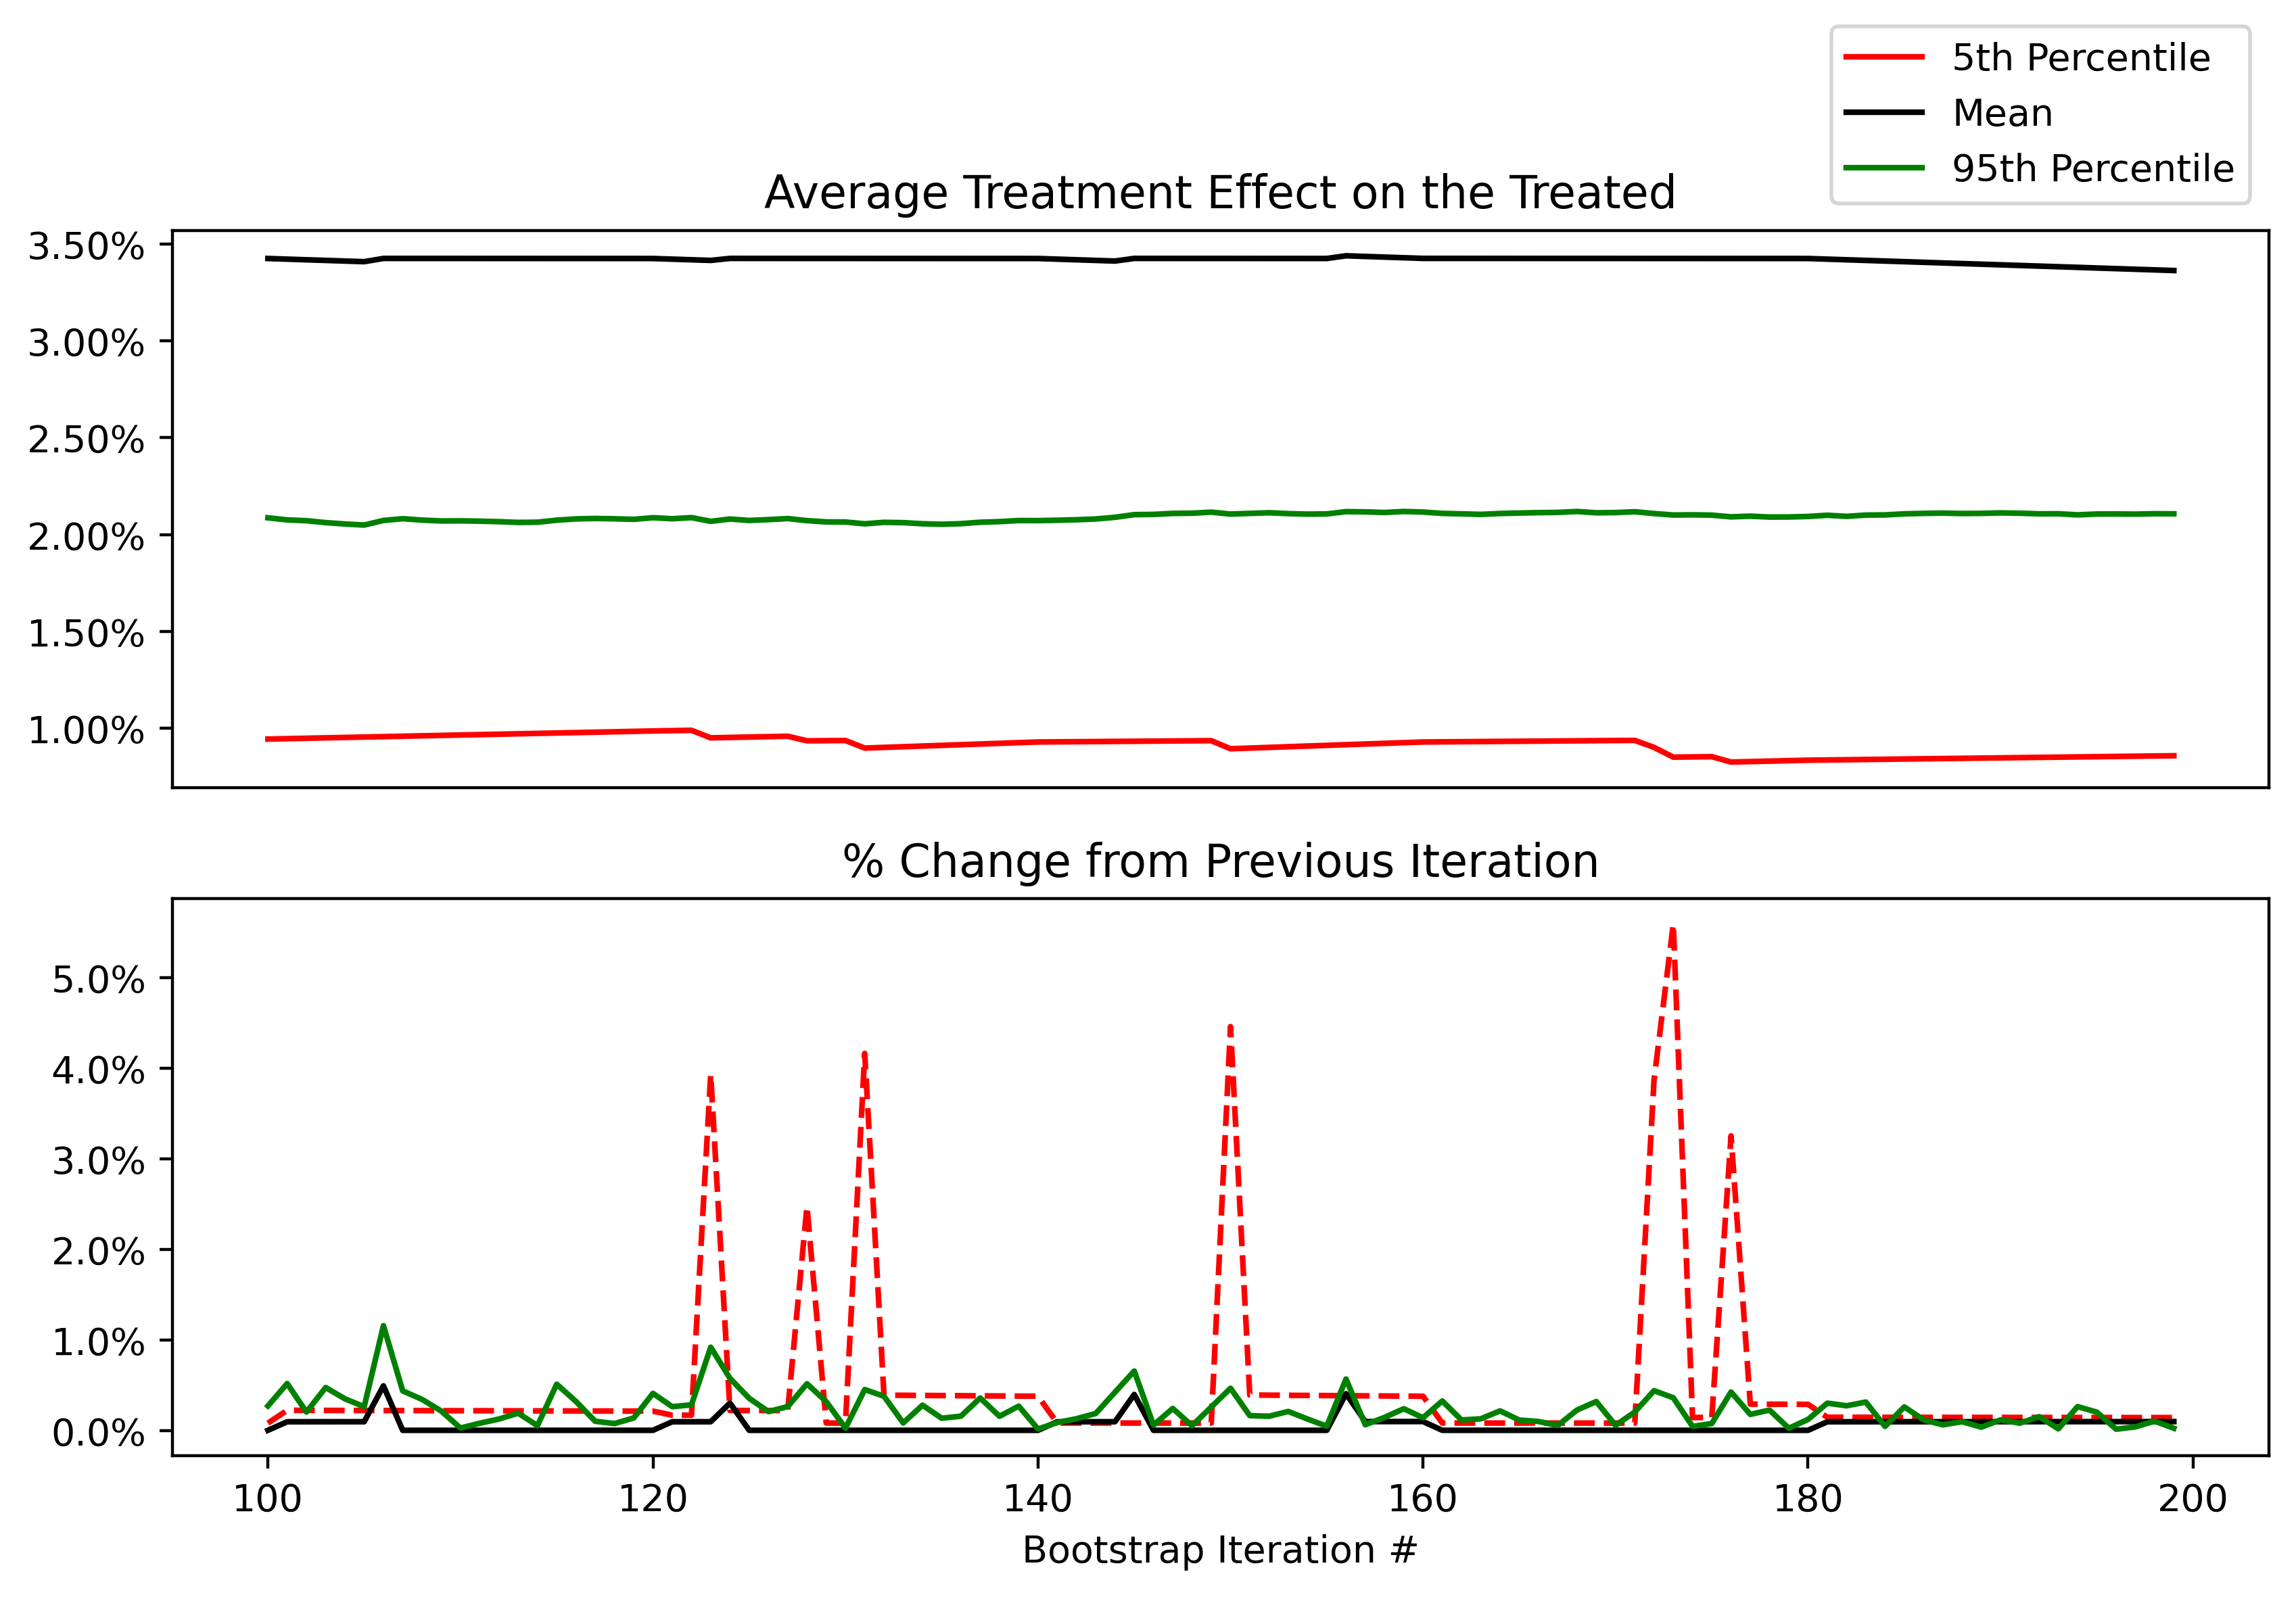

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), dpi=400);

plt1 = axs[0]
plt2 = axs[1]

start_idx = 100
end_idx = 200

# start_idx = 750
# end_idx = 1500

# start_idx = 1500
# end_idx = 2250

plt1.plot(range(start_idx, end_idx), p_05s[start_idx:end_idx], color='r', label='5th Percentile');
plt1.plot(range(start_idx, end_idx), p_95s[start_idx:end_idx], color='k', label='Mean');
plt1.plot(range(start_idx, end_idx), means[start_idx:end_idx], color='g', label='95th Percentile');
plt1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
plt1.set_title('Average Treatment Effect on the Treated')
plt1.axes.get_xaxis().set_visible(False);
plt1.legend(bbox_to_anchor=(1.0, 1.4), loc='upper right');

plt2.plot(range(start_idx, end_idx), pd_p_05s[start_idx:end_idx], color='r', linestyle='dashed', label='5th Percentile');
plt2.plot(range(start_idx, end_idx), pd_p_95s[start_idx:end_idx], color='k', label='Mean');
plt2.plot(range(start_idx, end_idx), pd_means[start_idx:end_idx], color='g', label='95th Percentile');
plt2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
plt2.set_title('% Change from Previous Iteration');
plt2.set_xlabel('Bootstrap Iteration #');

# plt.savefig('bs_200_400.png')

In [136]:
def show_stats(start, end):
    print(
        f"Bootstrap sample range: {start}-{end}\n"
        f"Average % difference in mean: {np.array(pd_means[start:end]).mean():0.3%}\n"
        f"Average absolute difference in mean: {np.array(ad_means[start:end]).mean()*100*100:0.1f} bps\n"
        f"Average % difference in p_05: {np.array(pd_p_05s[start:end]).mean():0.3%}\n"
        f"Average absolute difference in p_05: {np.array(ad_p_05s[start:end]).mean()*100*100:0.1f} bps\n"
    )

show_stats(0, 100)
show_stats(100, 200)
show_stats(200, 300)

Bootstrap sample range: 0-100
Average % difference in mean: 1.129%
Average absolute difference in mean: 2.7 bps
Average % difference in p_05: 1.861%
Average absolute difference in p_05: 3.0 bps

Bootstrap sample range: 100-200
Average % difference in mean: 0.229%
Average absolute difference in mean: 0.5 bps
Average % difference in p_05: 0.466%
Average absolute difference in p_05: 0.4 bps

Bootstrap sample range: 200-300
Average % difference in mean: 0.126%
Average absolute difference in mean: 0.3 bps
Average % difference in p_05: 0.363%
Average absolute difference in p_05: 0.3 bps

